In [1]:
# Dependencies
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.stats import linregress
import numpy as np
from sklearn import datasets

# Read in the csv file with the information from Spotify.¶


In [2]:

hot100 = os.path.join("data", "Hot100AudioFeatures.csv")

# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hot_100_df = pd.read_csv(hot100, encoding="ISO-8859-1")
hot_100_df.head()

,ï»¿SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,True,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,True,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


## Clean up the dataframe by removing some columns and eliminating rows that have no information.

In [3]:

hot100_clean_df = hot_100_df.drop(columns=['ï»¿SongID','spotify_track_preview_url','spotify_track_album','spotify_track_explicit','spotify_track_duration_ms'],axis=1)

hot100_clean_df.dropna(inplace=True)

hot100_clean_df.reset_index(inplace=True)

hot100_clean_df


,index,Performer,Song,spotify_genre,spotify_track_id,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0,"Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.017000,0.000016,0.1790,0.623,80.002,4.0
1,2,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.371000,0.000000,0.2310,0.323,95.799,4.0
2,3,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,86.0,0.542,0.674,6.0,-4.169,1.0,0.2100,0.058800,0.000000,0.0955,0.667,76.388,4.0
3,4,"Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,61.0,0.948,0.623,8.0,-5.725,0.0,0.1680,0.001240,0.000001,0.0716,0.856,135.979,4.0
4,5,Taylor Swift,The Archer,"['dance pop', 'pop', 'post-teen pop']",3pHkh7d0lzM2AldUtz2x37,76.0,0.292,0.574,0.0,-9.375,1.0,0.0401,0.120000,0.005690,0.0663,0.166,124.344,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23560,28486,Genesis,"Tonight, Tonight, Tonight","['album rock', 'art rock', 'classic rock', 'me...",3qmYlsTbC9CD9SGoVmaEDa,42.0,0.571,0.502,7.0,-14.405,1.0,0.0303,0.015800,0.014000,0.0849,0.316,98.058,4.0
23561,28487,The Smashing Pumpkins,"Tonight, Tonight","['alternative metal', 'alternative rock', 'gru...",7bu0znpSbTks0O6I98ij0W,69.0,0.287,0.670,6.0,-9.381,1.0,0.0368,0.000063,0.748000,0.2370,0.222,148.928,4.0
23562,28488,Rod Stewart,Tonight's The Night (Gonna Be Alright),"['adult standards', 'mellow gold', 'soft rock']",10LRRKPmx8uHcSxLVWK0ct,55.0,0.550,0.514,11.0,-12.617,1.0,0.0523,0.336000,0.125000,0.3820,0.724,136.542,3.0
23563,28489,BLACKstreet,Tonight's The Night,"['boy band', 'dance pop', 'hip hop', 'hip pop'...",3scEwKiAkfdPUdZ6k1AEoW,32.0,0.585,0.573,6.0,-5.561,0.0,0.0759,0.133000,0.000011,0.1730,0.591,76.060,4.0


# Read in the csv file with the list of top 100 songs from 1958 to 2019

## Clean up the file by fixing column names and finding the highest that a song had made it in the top 100 billboards

In [4]:
hotstuff = os.path.join("data", "HotStuff.csv")

# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
hotstuff_df = pd.read_csv(hotstuff, encoding="ISO-8859-1")
hotstuff_df.rename(columns = {'ï»¿url':'URL'},inplace=True)
hotstuff_df


,URL,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,http://www.billboard.com/charts/hot-100/2006-0...,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,http://www.billboard.com/charts/hot-100/2009-1...,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...
320490,https://www.billboard.com/charts/hot-100/2019-...,1/5/2019,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25
320491,https://www.billboard.com/charts/hot-100/2019-...,12/7/2019,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26
320492,https://www.billboard.com/charts/hot-100/2019-...,12/14/2019,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27
320493,https://www.billboard.com/charts/hot-100/2019-...,12/21/2019,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28


In [5]:
# Group by song to get the highest position and create a dataframe out of it.

hotstuff_song = hotstuff_df.groupby('Song')
hotstuff_clean = pd.DataFrame(hotstuff_song['Peak Position'].min())

# merge this with the earlier dataframes to give us the main dataframe to work from.  Clear out any fows with missing data
hotstuff_merge = pd.merge(hotstuff_clean , hot100_clean_df, how='inner', on='Song')
hotstuff_merge.dropna(inplace=True)

# This is the final dataframe.
hotstuff_merge

,Song,Peak Position,index,Performer,spotify_genre,spotify_track_id,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"""B"" Girls",54,10308,Young And Restless,[],0rWUHulFlScxQsCq7kWKde,20.0,0.615,0.497,7.0,-11.913,1.0,0.4390,0.0160,0.000000,0.3120,0.769,193.762,3.0
1,"""Cherry Cherry"" from Hot August Night",31,12928,Neil Diamond,"['adult standards', 'brill building pop', 'fol...",18ocy9Be9SxWEEnOLGDfkS,16.0,0.340,0.948,9.0,-5.061,1.0,0.1370,0.0941,0.000907,0.8670,0.604,172.349,4.0
2,#1,22,12460,Nelly,"['dance pop', 'hip hop', 'pop', 'pop rap', 'ra...",7rSj5gEdN5KgHwbnEVAZ4b,50.0,0.792,0.600,7.0,-6.157,1.0,0.2280,0.0236,0.000000,0.4190,0.463,89.985,4.0
3,#1 Dee Jay,82,20117,Goody Goody,['pop rap'],1tU3tJHbokVFAwD11zMuv7,0.0,0.859,0.376,7.0,-16.542,0.0,0.0439,0.0536,0.096300,0.0605,0.902,127.202,4.0
4,#9 Dream,9,2036,John Lennon,"['album rock', 'classic rock', 'folk rock', 'm...",4ZVWvCUwsOnIGmJMj71RkG,55.0,0.406,0.597,0.0,-11.745,1.0,0.0336,0.0744,0.013300,0.2540,0.478,115.474,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23558,idontwannabeyouanymore,96,15485,Billie Eilish,"['electropop', 'pop']",41zXlQxzTi6cGAjpOXyLYH,86.0,0.483,0.412,7.0,-8.461,1.0,0.0402,0.7370,0.000000,0.1160,0.247,170.163,3.0
23559,sobeautiful,84,22955,Musiq Soulchild,"['alternative r&b', 'dance pop', 'neo soul', '...",2PN3gbuBn5WBEwrEJH3xiu,59.0,0.689,0.562,7.0,-7.048,0.0,0.0637,0.0656,0.000000,0.0885,0.210,133.987,4.0
23560,teachme,42,6128,Musiq Soulchild,"['alternative r&b', 'dance pop', 'neo soul', '...",0ODFPypnJLE6hKgahiuSzn,57.0,0.499,0.610,8.0,-5.110,0.0,0.1350,0.4730,0.000000,0.0722,0.436,172.969,3.0
23561,whoa (mind in awe),37,25353,XXXTENTACION,"['emo rap', 'miami hip hop']",7pdF27mSDuPWhppnHAmWHa,77.0,0.735,0.525,6.0,-2.939,0.0,0.0441,0.6530,0.918000,0.1010,0.369,160.147,4.0


In [48]:
#Adding function to plot information
def plot_func(xvalues,yvalues,x_loc,y_loc,x_label,y_label,title):
    
    # Generate the pearson coeeficient
    correlation = sts.pearsonr(xvalues,yvalues)
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    print(f"The p-value is {round(correlation[1],3)}")

    # Get the linear regression model
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)

    # Create the line using the slope and intercept and print out the formula
    regress_values = xvalues * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot information
    plt.scatter(xvalues,yvalues)
    plt.plot(xvalues,regress_values,"r-")
    plt.annotate(line_eq,(x_loc,y_loc),fontsize=15,color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


The correlation between both factors is -0.26
The p-value is 0.0


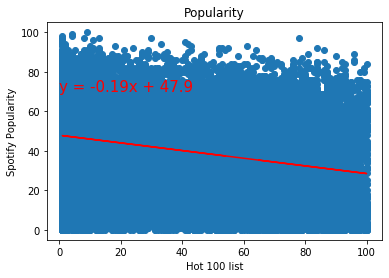

In [12]:
# create a scatter plot based on the peak ranking versus the spotify track popularity.  
# We need to repeat this for the other factors

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['spotify_track_popularity'],0,70,'Hot 100 list',
          'Spotify Popularity','Popularity')


The correlation between both factors is -0.01
The p-value is 0.021


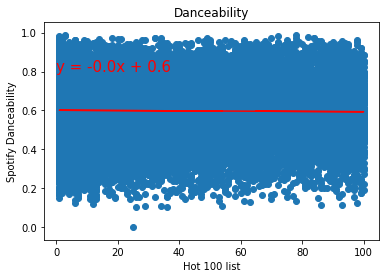

In [13]:
# create a scatter plot based on the peak ranking versus the danceability.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['danceability'],0,.8,'Hot 100 list',
          'Spotify Danceability','Danceability')


The correlation between both factors is 0.03
The p-value is 0.0


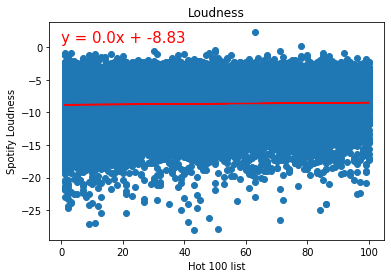

In [14]:
# create a scatter plot based on the peak ranking versus the loudness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['loudness'],0,.8,'Hot 100 list',
          'Spotify Loudness','Loudness')

The correlation between both factors is 0.03
The p-value is 0.0


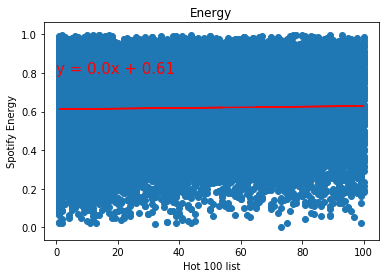

In [15]:
# create a scatter plot based on the peak ranking versus the Energy.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['energy'],0,.8,'Hot 100 list',
          'Spotify Energy','Energy')

The correlation between both factors is 0.07
The p-value is 0.0


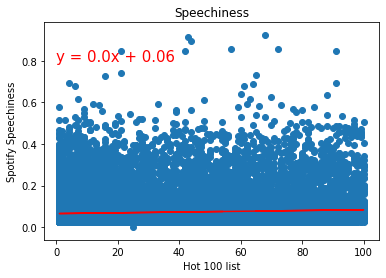

In [20]:
# create a scatter plot based on the peak ranking versus the Speechiness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['speechiness'],0,.8,'Hot 100 list',
          'Spotify Speechiness','Speechiness')


The correlation between both factors is 0.03
The p-value is 0.0


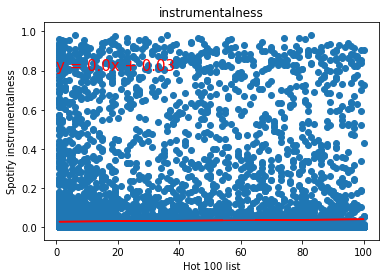

In [21]:
# create a scatter plot based on the peak ranking versus the Instrumentalness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['instrumentalness'],0,.8,'Hot 100 list',
          'Spotify Instrumentalness','Instrumentalness')


The correlation between both factors is 0.0
The p-value is 0.596


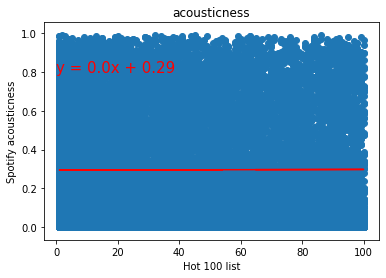

In [22]:
# create a scatter plot based on the peak ranking versus the acousticness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['acousticness'],0,.8,'Hot 100 list',
          'Spotify Acousticness','Acousticness')

The correlation between both factors is -0.02
The p-value is 0.001


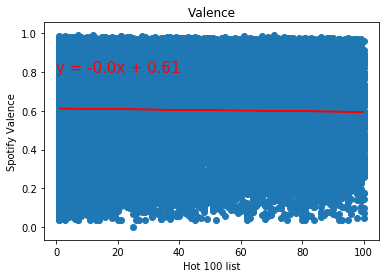

In [56]:
# create a scatter plot based on the peak ranking versus the Valence.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['valence'],0,.8,'Hot 100 list',
          'Spotify Valence','Valence')

The correlation between both factors is 0.02
The p-value is 0.003


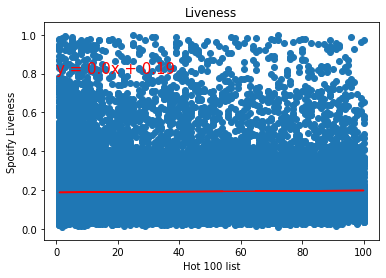

In [49]:
# create a scatter plot based on the peak ranking versus the Liveness.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['liveness'],0,.8,'Hot 100 list',
          'Spotify Liveness','Liveness')

The correlation between both factors is 0.01
The p-value is 0.039


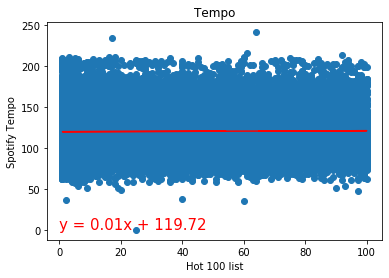

In [50]:
# create a scatter plot based on the peak ranking versus the Tempo.  

plot_func(hotstuff_merge['Peak Position'], hotstuff_merge['tempo'],0,.8,'Hot 100 list',
          'Spotify Tempo','Tempo')

In [38]:
hot100_stat = hotstuff_merge.copy()
hot100_stat.drop(columns=['index','spotify_track_popularity','key','mode','time_signature'],inplace=True)
hot100_stat_group = hot100_stat.groupby("Peak Position")
group_mean = hot100_stat_group.mean()
group_median = hot100_stat_group.median()

mean_df = pd.DataFrame(hot100_stat_group.mean())
median_df = pd.DataFrame(hot100_stat_group.median())
hot100_stat_merge = pd.merge(mean_df,median_df,how='inner',on='Peak Position',suffixes=('_Mean','_Median'))
hot100_stat_merge

,danceability_Mean,energy_Mean,loudness_Mean,speechiness_Mean,acousticness_Mean,instrumentalness_Mean,liveness_Mean,valence_Mean,tempo_Mean,danceability_Median,energy_Median,loudness_Median,speechiness_Median,acousticness_Median,instrumentalness_Median,liveness_Median,valence_Median,tempo_Median
Peak Position,,,,,,,,,,,,,,,,,,
1,0.607463,0.608656,-8.659460,0.062882,0.296876,0.030153,0.179160,0.594780,118.444124,0.6190,0.6180,-8.2405,0.03955,0.2040,5.850000e-06,0.1250,0.6205,117.4735
2,0.596031,0.599783,-8.837852,0.061049,0.313798,0.031498,0.192132,0.605315,118.646432,0.6120,0.6165,-8.3340,0.03935,0.2225,5.500000e-06,0.1370,0.6200,117.0520
3,0.627319,0.622007,-8.757052,0.066494,0.290995,0.031728,0.185741,0.633535,120.197702,0.6355,0.6420,-8.3370,0.04055,0.1995,6.825000e-06,0.1245,0.6585,119.8880
4,0.605877,0.612104,-8.849665,0.071327,0.294755,0.030900,0.185354,0.620325,118.520305,0.6200,0.6400,-8.3640,0.03980,0.2100,6.420000e-06,0.1250,0.6470,115.6400
5,0.599086,0.615219,-8.914012,0.061925,0.286940,0.016797,0.189201,0.610194,119.056338,0.6100,0.6370,-8.4380,0.03870,0.1900,9.720000e-06,0.1240,0.6190,118.4290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.586106,0.641076,-8.556553,0.071928,0.335625,0.060537,0.208620,0.606837,120.378285,0.5960,0.6940,-7.8640,0.04300,0.2440,3.400000e-06,0.1410,0.6080,118.6360
97,0.572035,0.624884,-8.299119,0.083543,0.352821,0.053865,0.198000,0.627189,122.401049,0.5890,0.6080,-8.1970,0.04120,0.3140,2.990000e-06,0.1390,0.6620,120.9400
98,0.610960,0.609405,-8.595008,0.084397,0.320101,0.042922,0.184587,0.621084,123.560778,0.6135,0.6160,-8.2640,0.04360,0.2710,1.990000e-06,0.1240,0.6315,119.9335


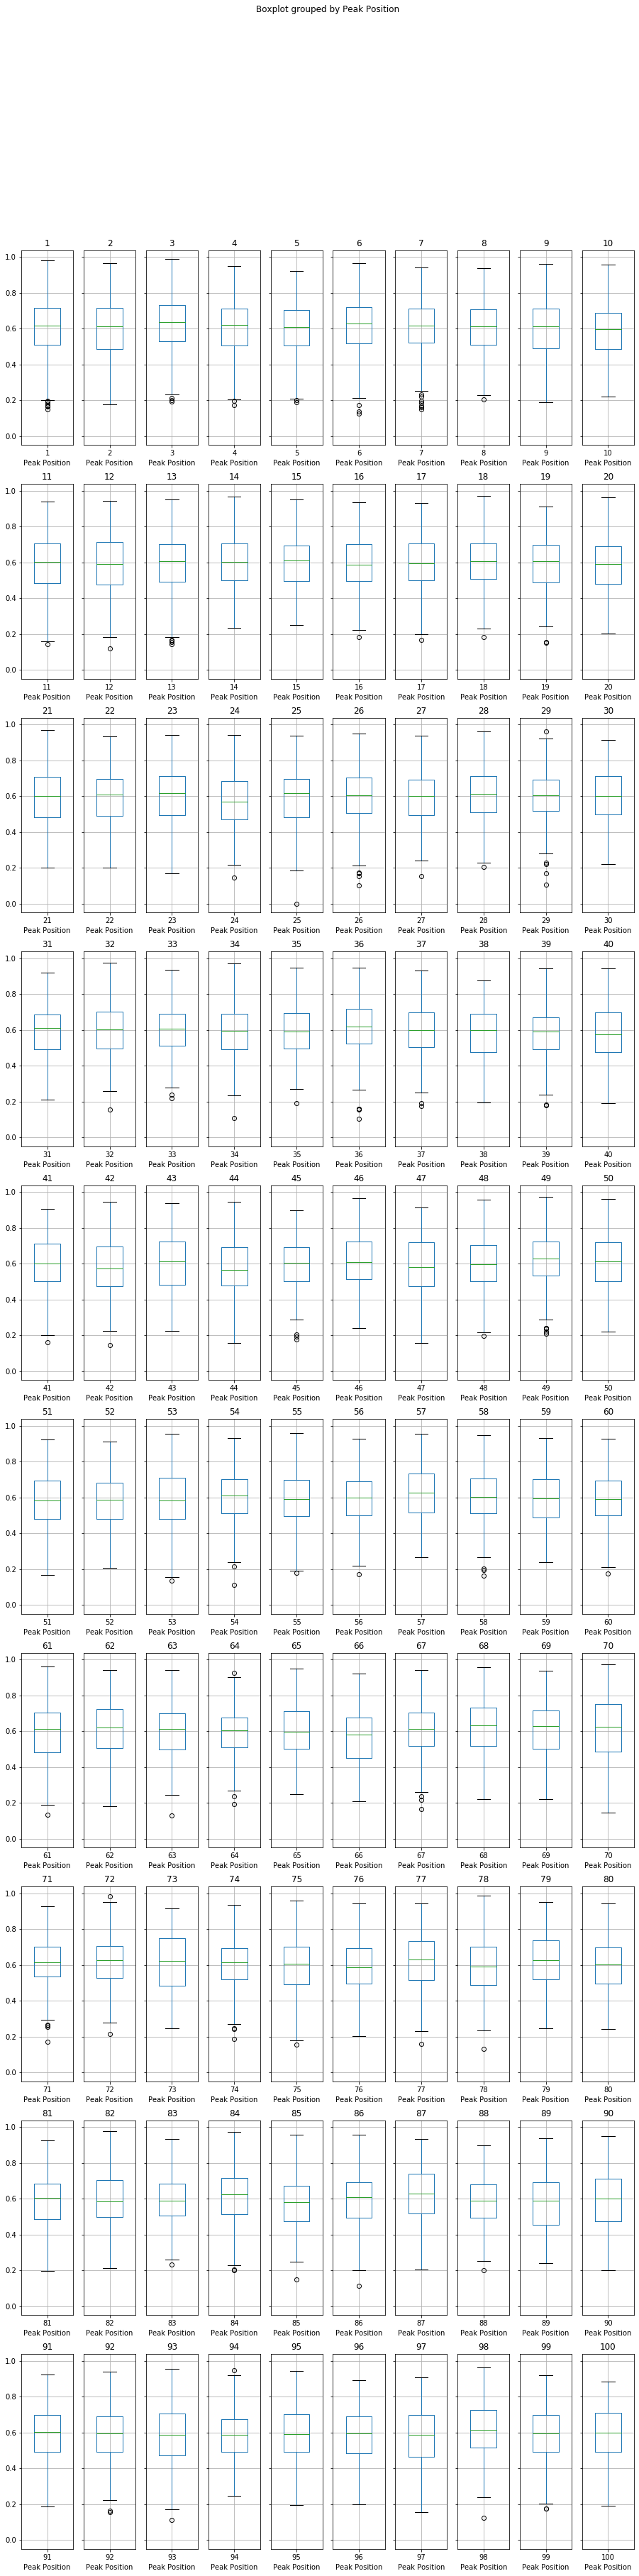

In [55]:
# Plot the information for all four Regimens
peak_plot = hot100_stat_group.boxplot(by ='Peak Position', column =['danceability'], grid = True,widths=0.5,figsize=(15,60)) 
hot100_stat_group.set_ylabel = 'Danceability'
plt.show()

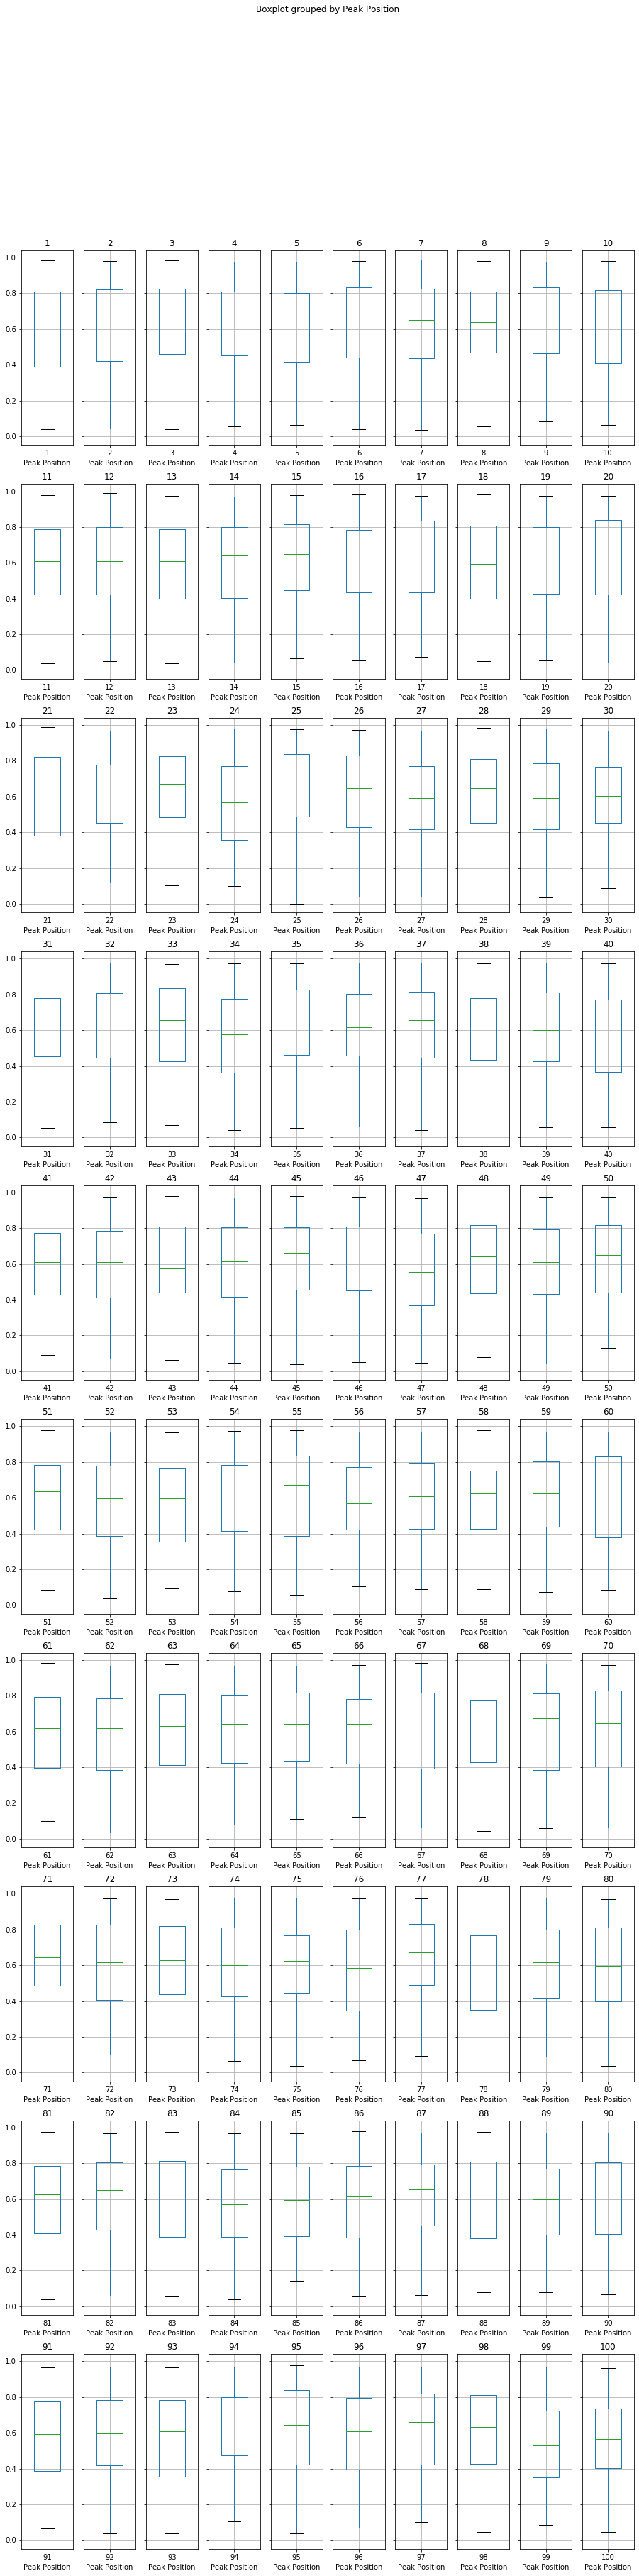

In [56]:
# Plot the information for all four Regimens
peak_plot = hot100_stat_group.boxplot(by ='Peak Position', column =['valence'], grid = True,widths=0.5,figsize=(15,60)) 
hot100_stat_group.set_ylabel = 'Valence'
plt.show()

# This section looks at creating the list of Genres from the datafile.

In [35]:
genre_dict ={}

for x in range(len(hotstuff_merge)):
    
    listfield = hotstuff_merge.loc[x,'spotify_genre']
    result_str = ""

    for i in range(0, len(listfield)): 
        if (listfield[i] != '[') and (listfield[i] != ']') and (listfield[i] != "'"): 
            result_str = result_str + listfield[i] 
    if len(listfield) != 0:
        listfield = result_str.split(",")
        for g in listfield:

            if g in genre_dict:
                genre_dict[g] = genre_dict[g] + 1
            else:
                genre_dict[g] = 1

#print(genre_dict)

dict_df = pd.DataFrame(list(genre_dict.items()),columns=['Genre','count'])
dict_df


,Genre,count
0,,1439
1,adult standards,3198
2,brill building pop,1969
3,folk,1039
4,folk rock,2330
...,...,...
1373,psychill,1
1374,progressive psytrance,1
1375,euro hi-nrg,1
1376,west coast rap,1


In [36]:
# save the file to be shared
dict_df.to_csv('data/genrefile.csv')

# This section can be used if we want to pull in recent data (2020).

In [43]:
# After pulling file from spotify chart. skip the first row and import the csv file into a dataframe.  Also split out the
# Track identifier which will be used in the next cell.

july15 = os.path.join("data", "july15.csv")

# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
july15_df = pd.read_csv(july15, encoding="ISO-8859-1", skiprows=1)
july15_df[['Base URL','Track Identifier']] = july15_df.URL.str.split("track/",expand=True,)
july15_df.head()

,Position,Track Name,Artist,Streams,URL,Base URL,Track Identifier
0,1,ROCKSTAR (feat. Roddy Ricch),DaBaby,5287167,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,https://open.spotify.com/,7ytR5pFWmSjzHJIeQkgog4
1,2,Savage Love (Laxed - Siren Beat),Jawsh 685,4847209,https://open.spotify.com/track/1xQ6trAsedVPCdb...,https://open.spotify.com/,1xQ6trAsedVPCdbtDAmk0c
2,3,Blinding Lights,The Weeknd,4357126,https://open.spotify.com/track/0VjIjW4GlUZAMYd...,https://open.spotify.com/,0VjIjW4GlUZAMYd2vXMi3b
3,4,Come & Go (with Marshmello),Juice WRLD,4031110,https://open.spotify.com/track/7y7w4tl4MaRC2UM...,https://open.spotify.com/,7y7w4tl4MaRC2UMEj1mPtr
4,5,Watermelon Sugar,Harry Styles,3825086,https://open.spotify.com/track/6UelLqGlWMcVH1E...,https://open.spotify.com/,6UelLqGlWMcVH1E5c4H7lY


In [51]:
# Create an empty dataframe to pull in the current top 100.
july_df = pd.DataFrame()

# This code steps through the dataframe and pulls the information from Spotify.  In this example I printed
# out the danceability of the song.  Also I display an example of the JSON file returned.
#july_df = pd.DataFrame(columns=['Position','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo'])


for row_index,row in july15_df.iterrows():

    client_credentials_manager = SpotifyClientCredentials(client_id='09b1d71bfca845e9b744f70294704da2',
                           client_secret='581c60a4f6c347be9a749bf0a1bb5634')
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


    if len(sys.argv) > 1:
        features = sp.audio_features(row['Track Identifier'])
        
#    print(f'Track Name {row["Track Name"]} danceability is: {features[0]["danceability"]}')

    # append the informtion to the empty DataFrame
    july_df = july_df.append(features[0],ignore_index=True)
    
    # we only want 100
    if row_index >= 99:
        break
       


In [53]:
july_df.drop(columns=['analysis_url','duration_ms','id','key','mode','time_signature','track_href','type','uri'],inplace=True)
july_df

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.24700,0.746,0.690,0.000000,0.1010,-7.956,0.1640,89.977,0.497
1,0.23400,0.767,0.481,0.000000,0.2690,-8.520,0.0803,150.076,0.761
2,0.00146,0.514,0.730,0.000095,0.0897,-5.934,0.0598,171.005,0.334
3,0.01720,0.625,0.814,0.000000,0.1580,-5.181,0.0657,144.991,0.535
4,0.12200,0.548,0.816,0.000000,0.3350,-4.209,0.0465,95.390,0.557
...,...,...,...,...,...,...,...,...,...
95,0.86600,0.464,0.473,0.000000,0.1090,-10.086,0.1290,75.801,0.604
96,0.18500,0.544,0.744,0.000000,0.3360,-5.007,0.0889,73.699,0.572
97,0.16200,0.760,0.658,0.000000,0.1950,-5.275,0.2750,100.202,0.565
98,0.00815,0.688,0.647,0.000017,0.0950,-7.258,0.1900,88.834,0.195


In [ ]:
[
    {
        "danceability": 0.746,
        "energy": 0.69,
        "key": 11,
        "loudness": -7.956,
        "mode": 1,
        "speechiness": 0.164,
        "acousticness": 0.247,
        "instrumentalness": 0,
        "liveness": 0.101,
        "valence": 0.497,
        "tempo": 89.977,
        "type": "audio_features",
        "id": "7ytR5pFWmSjzHJIeQkgog4",
        "uri": "spotify:track:7ytR5pFWmSjzHJIeQkgog4",
        "track_href": "https://api.spotify.com/v1/tracks/7ytR5pFWmSjzHJIeQkgog4",
        "analysis_url": "https://api.spotify.com/v1/audio-analysis/7ytR5pFWmSjzHJIeQkgog4",
        "duration_ms": 181733,
        "time_signature": 4
    }
]
​